# Decision Tree

In addition to the model using logistic regression to predict the outcome of an animal, we also wanted to gain some further insight into which features of the animals influence the outcome.
For this purpose we decided to use a decision tree because it offers a very nice way to visualize how the animals are classifed and the results can be interpreted easily.
When training the decision tree we used cross validation to tune many of the possible hyperparameters (see the section on training), however for some of the hyperparamters, e.g. the minimal number of animals per leaf, we used the deafult parameters because they already give sensible results.
The maximal depth of the tree was set to 5 because this prevents the model from becoming too convolved and it makes sure that the results generalize well.

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, svm, preprocessing, metrics, ensemble, tree
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## load  and prepare data

In [3]:
#read in the data with numerical features
data = pd.read_csv('data/transformed_data_num.csv',index_col=0)
data.dropna(inplace=True)

In [4]:
data.head(10)

,outcometype,animaltype,sex,age,year,neutralized,colormix,breedmix,apricot,black,black.1,blue,blue.1,brindle,brown,buff,calico,chocolate,cream,fawn,flame,gold,gray,lilac,liver,lynx,merle,orange,point,red,sable,seal,silver,smoke,tabby,tan,tick,tiger,torbie,tortie,tricolor,white,yellow,affenpinscher,airedale,akita,alaskan,american,anatol,angora,apso,argentino,australian,basenji,basset,bay,beagle,beauceron,belgian,bernard,bernese,bichon,black.2,black.3,bloodhound,blue.2,blue.3,bluetick,bobtail,border,boston,boxer,brittany,bruss,bull,bulldog,bullmastiff,cairn,cane,cardigan,carolina,catahoula,cattle,cavalier,chesa,chihuahua,chinese,chow,coat,coated,cocker,collie,coon,coonhound,corgi,corso,cur,dachshund,dalmatian,dane,doberman,dog,dogo,domestic,dutch,english,eskimo,feist,finnish,flat,fox,french,frise,german,golden,great,greyhound,griffon,hair,harrier,havanese,heeler,highland,himalayan,hound,husky,inu,irish,italian,jack,japanese,kelpie,labrador,lacy,landseer,leonberger,lhasa,longhair,maine,malamute,malinois,maltese,manchester,manx,mastiff,medium,miniature,mountain,mouth,newfoundland,norfolk,norwich,papillon,parson,patterdale,pbgv,pekingese,pembroke,persian,pharaoh,pinsch,pinscher,pit,plott,pointer,pomeranian,poodle,pug,pyrenees,queensland,ragdoll,rat,redbone,retr,retriever,rhod,ridgeback,rottweiler,rough,russell,russian,schipperke,schnauzer,sharpei,sheepdog,shepherd,shetland,shiba,shih,shorthair,siamese,siberian,silky,smooth,snowshoe,soft,span,spaniel,spitz,springer,st,staffordshire,standard,swedish,terr,terrier,tibetan,toy,treeing,tzu,vallhund,vizsla,walker,weimaraner,welsh,west,wheaten,whippet,wire,wirehair,wolfhound,yorkshire,april,august,december,february,january,july,june,march,may,november,october,september,friday,monday,saturday,sunday,thursday,tuesday,wednesday
AnimalID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Return_to_owner,1.0,0.0,0.090683,0.333333,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Euthanasia,0.0,1.0,0.090683,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.

In [5]:
#prepare data
X = np.array(data.drop('outcometype',axis=1))
Y = np.array(data.outcometype)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X,Y,train_size=0.7)

## train the model

In [6]:
#search a good model
tr = tree.DecisionTreeClassifier()

param_dict = {'max_depth':[5], 'criterion':["gini", "entropy"], 'max_features':['auto', None], 
              'splitter':['best', 'random']}

clf = model_selection.GridSearchCV(tr, param_grid = param_dict, n_jobs = -1)

clf.fit(x_train,y_train)

print(clf.best_score_)
print(clf.best_params_)

results = pd.DataFrame(clf.cv_results_)

results

0.6343030345799343
{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'splitter': 'best'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.197818,0.012115,0.023123,0.002666,gini,5,auto,best,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.497260,0.483127,0.486588,0.453418,0.495384,0.483155,0.015777,7
1,0.164737,0.024101,0.016159,0.001563,gini,5,auto,random,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.605423,0.444188,0.444188,0.449668,0.509233,0.490540,0.062474,6
2,0.815329,0.029056,0.032355,0.003398,gini,5,None,best,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.636862,0.630228,0.623594,0.637727,0.643104,0.634303,0.006738,1
3,1.023252,0.231145,0.020957,0.001963,gini,5,None,random,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.629363,0.629651,0.613787,0.635420,0.638200,0.629284,0.008455,4
4,0.299580,0.008291,0.033626,0.010616,entropy,5,auto,best,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.591289,0.559562,0.428613,0.441015,0.435372,0.491170,0.069633,5
5,0.263653,0.006717,0.028898,0.006728,entropy,5,auto,random,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.458898,0.435823,0.559850,0.437554,0.450087,0.468442,0.046479,8
6,1.033925,0.028070,0.016214,0.000647,entropy,5,None,best,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.637439,0.629939,0.623882,0.632535,0.633583,0.631476,0.004498,2
7,0.542425,0.221655,0.012165,0.003512,entropy,5,None,random,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.634266,0.630805,0.619556,0.638016,0.624928,0.629514,0.006584,3


## results

In the confusion matrices below one can see that the model makes some mispredictions, especially regarding the rare labels 'died' and 'euthanasia', but it also has a hard time with differentiating 'adoption' from 'transfer' and 'return'.
The overall accuracy scores on the training and testing data however are not bad and since they are very similar this means that the results generalize very well.
The plot of the decision tree (its best to view the pdf file) gives some hints as to what influences the outcome of the individual animals.

In [7]:
#training score
clf.score(x_train,y_train)

0.6389177339333103

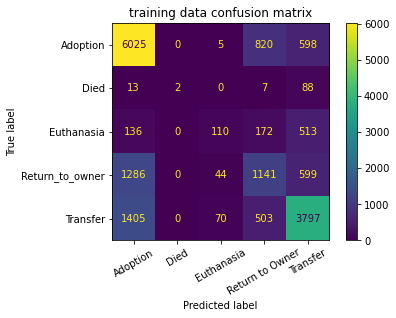

In [8]:
fig,ax = plt.subplots()
metrics.ConfusionMatrixDisplay.from_estimator(clf,x_train,y_train,ax=ax)
ax.set_title('training data confusion matrix')
ax.set_xticklabels(labels=['Adoption','Died','Euthanasia','Return to Owner','Transfer'],rotation=30)
plt.show()

In [9]:
#testing score
clf.score(x_test,y_test)

0.637685060565276

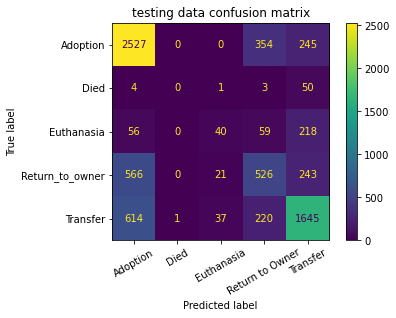

In [10]:
fig,ax = plt.subplots()
metrics.ConfusionMatrixDisplay.from_estimator(clf,x_test,y_test,ax=ax)
ax.set_title('testing data confusion matrix')
ax.set_xticklabels(labels=['Adoption','Died','Euthanasia','Return to Owner','Transfer'],rotation=30)
plt.show()

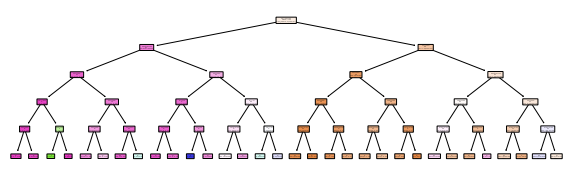

In [11]:
#plot the tree
fig = plt.figure(figsize=(10,3))
tree.plot_tree(clf.best_estimator_,feature_names=data.columns[1:] ,rounded=True, filled =True, 
               impurity=False, label='root', class_names=['Adoption', 'Died', 'Euthanasia', 'Return', 'Transfer'])
plt.show()
#fig.savefig('tree.pdf')